In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os, sys
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Input,Sequential,load_model,Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda, add,concatenate,GlobalAveragePooling2D,PReLU
from keras.initializers import he_normal,glorot_normal,glorot_uniform
import tensorflow_addons as tfa
from keras import utils
import keras.backend as K
import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from keras import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import gc
import os
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [ ]:

sgd_initial_learning_rate=0.001
Adam_initial_learning_rate=0.00001
batch_size = 64
epochs = 100
lr=0.001
patience_iter = 1
patience=10
best_model_file = '/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/LightCnn_blackman_frames864_sgd_epochs_batch32.h5'


In [ ]:
#img_rows=256,FrameLen=256,FrameInc=64,NFFT=800,winfunc=np.blackman
num_classes = 2
def featProcess():
    trainData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/train/train.npy')
    trainLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/train_lable/train_lable.npy')
    
    devData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/dev/dev.npy')
    devLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/dev_lable/dev_lable.npy')

    #evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_256time_256frame_length_64step_800fft/eval/eval_1.npy')
    #evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_256time_256frame_length_64step_800fft/eval_lable/eval_1_label.npy')
    
    #trainData = np.concatenate((trainData,devData))
    #trainLabel = np.concatenate((trainLabel,devLabel)) 
    
    img_rows, img_cols =trainData[0].shape
    
    x_train = trainData.reshape(trainData.shape[0], img_rows, img_cols, 1)
    y_train = keras.utils.np_utils.to_categorical(trainLabel,num_classes)
    #y_train = trainLabel
    
    x_dev = devData.reshape(devData.shape[0], img_rows, img_cols, 1)
    y_dev = keras.utils.np_utils.to_categorical(devLabel,num_classes)
    #y_dev = devLabel
    
    #x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
    #y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)
    #y_test = evalLabel
    
 
    return x_train,y_train,x_dev,y_dev#,x_test,y_test,evalLabel

In [ ]:
x_train,y_train,x_dev,y_dev= featProcess()

In [ ]:
class patchEmbeding2(tf.keras.layers.Layer):
    def __init__(self , num_of_patches, projection_dim):

      super(patchEmbeding2, self).__init__()
      self.num_of_patches=num_of_patches + 1
      self.projection_dim=projection_dim
      

      self.clstoken=tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 ,projection_dim)),trainable=True)

      self.positionalEmbedding=tf.keras.layers.Embedding(self.num_of_patches , projection_dim) #give a vector for each pateches
    def get_config(self):
        cfg = super().get_config()
        return cfg 
      
    def call(self, inputs):
      #projection=tf.keras.layers.Conv1D(128,1,1, activation='relu', input_shape=inputs.shape[2:],padding='same')(inputs)
      patches = tf.reshape(inputs ,(tf.shape(inputs)[0] , -1 , tf.shape(inputs)[3]))
      clstoken=tf.repeat(self.clstoken, tf.shape(inputs)[0],0) #repeat it with size of our batch_size
      #print('patches',patches.shape)
      #print('clstoken',clstoken.shape)

      patches=tf.concat((clstoken , patches), axis=1)
      #print('patches',patches.shape)

      positions=tf.range(0,self.num_of_patches,1)[tf.newaxis, ...]
      positionalEmbedding=self.positionalEmbedding(positions)
      #print('positionalEmbedding',positionalEmbedding.shape)
      patches = patches + positionalEmbedding


      return patches

In [ ]:
class patchEmbeding(tf.keras.layers.Layer):
    def __init__(self,size , num_of_patches, projection_dim):

      super(patchEmbeding, self).__init__()
      self.size=size
      self.num_of_patches=num_of_patches + 1
      self.projection_dim=projection_dim
      
      self.projection=tf.keras.layers.Dense(projection_dim)

      self.clstoken=tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 ,projection_dim)),trainable=True)

      self.positionalEmbedding=tf.keras.layers.Embedding(self.num_of_patches , projection_dim) #give a vector for each pateches
      
    def get_config(self):
        cfg = super().get_config()
        return cfg
    def call(self, inputs):
      patches=tf.image.extract_patches(inputs, sizes=[1, self.size , self.size ,1],
                                     strides=[1, self.size ,self.size ,1],
                                     rates=[1 ,1 ,1 ,1 ],
                                     padding="VALID")
      patches = tf.reshape(patches ,(tf.shape(inputs)[0] , -1 , self.size * self.size*128))
      patches=self.projection(patches)
      clstoken=tf.repeat(self.clstoken, tf.shape(inputs)[0],0) #repeat it with size of our batch_size
      #print('patches',patches.shape)
      #print('clstoken',clstoken.shape)

      patches=tf.concat((clstoken , patches), axis=1)
      #print('patches',patches.shape)

      positions=tf.range(0,self.num_of_patches,1)[tf.newaxis, ...]
      positionalEmbedding=self.positionalEmbedding(positions)
      #print('positionalEmbedding',positionalEmbedding.shape)
      patches = patches + positionalEmbedding


      return patches

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model = 512, num_heads = 8, causal=False, dropout=0.0):
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0
    depth = d_model // num_heads

    self.w_query = tf.keras.layers.Dense(d_model)
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth))  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))      

    self.w_value = tf.keras.layers.Dense(d_model)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))

    self.w_key = tf.keras.layers.Dense(d_model)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout)
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))

    self.dense = tf.keras.layers.Dense(d_model)

  def get_config(self):
        cfg = super().get_config()
        return cfg

  def call(self, inputs, mask=None, training=None):
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v

    query = self.w_query(q)
    query = self.split_reshape_query(query)    
    query = self.split_permute_query(query)                 

    value = self.w_value(v)
    value = self.split_reshape_value(value)
    value = self.split_permute_value(value)

    key = self.w_key(k)
    key = self.split_reshape_key(key)
    key = self.split_permute_key(key)

    if mask is not None:
      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])

    attention = self.attention([query, value, key], mask=mask)
    attention = self.join_permute_attention(attention)
    attention = self.join_reshape_attention(attention)

    x = self.dense(attention)

    return x

In [ ]:
class transformerLayer1(tf.keras.layers.Layer):
  def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
    super(transformerLayer1, self).__init__()

    self.multi_head_attention =  MultiHeadAttention(d_model, num_heads)
    self.dropout_attention = tf.keras.layers.Dropout(dropout)
    self.add_attention = tf.keras.layers.Add()
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dense2 = tf.keras.layers.Dense(d_model)
    self.dropout_dense = tf.keras.layers.Dropout(dropout)
    self.add_dense = tf.keras.layers.Add()
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)
  def get_config(self):
        cfg = super().get_config()
        return cfg

  def call(self, inputs, mask=None, training=None):
    # print(mask)
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask])
    attention = self.dropout_attention(attention, training = training)
    x = self.add_attention([inputs , attention])
    x = self.layer_norm_attention(x)
    # x = inputs

    ## Feed Forward
    dense = self.dense1(x)
    dense = self.dense2(dense)
    dense = self.dropout_dense(dense, training = training)
    x = self.add_dense([x , dense])
    x = self.layer_norm_dense(x)

    return x

In [ ]:
class TransformerEncoder1(tf.keras.layers.Layer):
    def __init__(self,d_model , heads, dff ,num_layers=1 ,dropout_rate=0.1):
      super().__init__()

      self.encoders=[transformerLayer1(d_model , heads , dff , dropout_rate) for _ in range(num_layers)] #stacking transformer layers in range of layers we define

    def get_config(self):
        cfg = super().get_config()
        return cfg 
    def call(self , inputs , training=True):
      x=inputs

      for layer in self.encoders:
        x=layer(x, training=training)

      return x

In [ ]:
class transformerLayer(tf.keras.layers.Layer):
    def __init__(self,d_model , heads, mlp_rate , dropout_rate=0.1):
      super().__init__()

      self.layernorm_1= tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.mha=tf.keras.layers.MultiHeadAttention(heads , d_model//heads , dropout=dropout_rate) #d_model is proj_dim

      self.layernorm_2= tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.mlp = tf.keras.Sequential([tf.keras.layers.Dense(d_model*mlp_rate , activation="gelu"),
                                      tf.keras.layers.Dropout(dropout_rate),
                                      tf.keras.layers.Dense(d_model , activation="gelu"),
                                      tf.keras.layers.Dropout(dropout_rate)])
    def get_config(self):
        cfg = super().get_config()
        return cfg 
      # we use training=True beacuse dropout shoudn't work in evaluation
    def call(self ,inputs , training=True):
      out_1 =self.layernorm_1(inputs)
      out_1=self.mha(out_1 , out_1 , training=training)
      out_1=inputs+out_1

      out_2=self.layernorm_2(out_1)
      out_2=self.mlp(out_2, training=training)
      out_2=out_1+ out_2

      return out_2

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self,d_model , heads, mlp_rate ,num_layers=1 ,dropout_rate=0.1):
      super().__init__()

      self.encoders=[transformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)] #stacking transformer layers in range of layers we define

    def get_config(self):
        cfg = super().get_config()
        return cfg 
    def call(self , inputs , training=True):
      x=inputs

      for layer in self.encoders:
        x=layer(x, training=training)

      return x

In [ ]:
def MFM(x):
    channels = x.shape[-1]
    mfm_out = tfa.layers.Maxout(int(channels / 2))(x)
    return mfm_out

def MFM_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4
    shape[-1] = shape[-1]/2
    return tuple(shape)

In [ ]:
def buildLcnn_T():
    input_tensor = Input(shape=x_train.shape[1:],name='input')
    x = Conv2D(32, (5,5), strides=(1,1), kernel_initializer=glorot_normal(),padding='same')(input_tensor)
    x = Lambda(MFM)(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

    x = Conv2D(32, (1,1),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Lambda(MFM)(x)
    x = Conv2D(64,(3,3),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Lambda(MFM)(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

    x = Conv2D(64, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Lambda(MFM)(x)
    x = Conv2D(96, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Lambda(MFM)(x) 
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	
    
    x = Conv2D(96, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Lambda(MFM)(x)
    x = Conv2D(128, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Lambda(MFM)(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	

    x = Conv2D(256, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Lambda(MFM)(x)
    x = Conv2D(256, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x) 
    x = Lambda(MFM)(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
  

    embedding=patchEmbeding2(144,128) #num_of_patches, projection_dim
    x=embedding(x)
    enc=TransformerEncoder1(128,8,1024) #d_model , heads, dff ,num_layers=1 ,dropout_rate=0.1
    encoderResualt=enc(x)
    clsResult=encoderResualt[:,0,:]
    drop_1=Dropout(0.2)(clsResult)
    dense_1=Dense(2*32 , activation="gelu")(drop_1)
    drop_2=Dropout(0.2)(dense_1)
    intermediary_model = keras.Model(input_tensor, drop_2)
    output=Dense((2), activation = "softmax")(drop_2)
    model = Model(input_tensor,output)
    return model,intermediary_model

In [ ]:
def buildcnn_T_relu():
    input_tensor = Input(shape=x_dev.shape[1:],name='input')
    x = Conv2D(16, (5,5), strides=(1,1), kernel_initializer=glorot_normal(),padding='same')(input_tensor)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)


    x = Conv2D(32,(3,3),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

    x = Conv2D(64, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	
    
    x = Conv2D(96, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	

    x = Conv2D(128, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
  

    embedding=patchEmbeding(1,144,128) #num_of_patches, projection_dim
    x=embedding(x)
    enc=TransformerEncoder1(128,8,1024,1,0.3) #d_model , heads, dff ,num_layers=1 ,dropout_rate=0.1
    encoderResualt=enc(x)
    clsResult=encoderResualt[:,0,:]
    drop_1=Dropout(0.2)(clsResult)
    dense_1=Dense(32*2 , activation="gelu")(drop_1)
    drop_2=Dropout(0.2)(dense_1)
    intermediary_model = keras.Model(input_tensor, drop_1)
    output=Dense((2), activation = "softmax")(drop_2)
    model = Model(input_tensor,output)
    return model,intermediary_model

In [ ]:
#del x_train,y_train
gc.collect()

50

In [ ]:
#model = buildLcnn_T()
#model.load_weights("/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/lcnn_T_blackman_frames864_sgd_epochs25_lr0.001.h5", by_name=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 400, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 16)      416       
                                                                 
 activation (Activation)     (None, 400, 400, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 200, 200, 32)      0         
                                                             

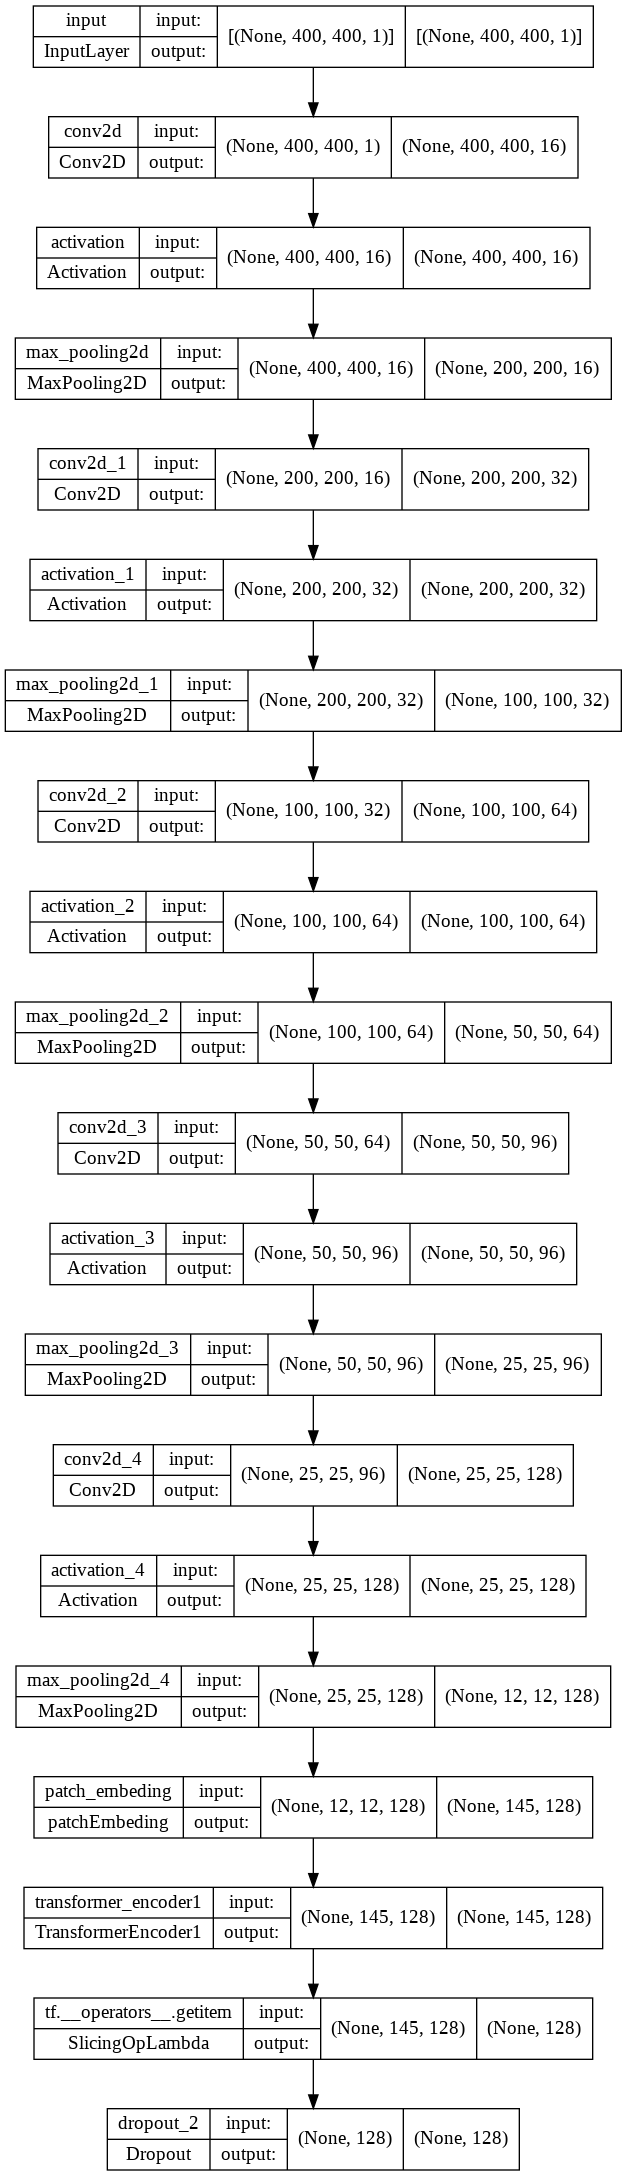

In [ ]:
model,intermediary_model = buildcnn_T_relu()
print(intermediary_model.summary())
from tensorflow.keras.utils import plot_model
plot_model(intermediary_model,to_file='model.png', show_shapes=True)

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9,nesterov=True)
adadelta = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.9, epsilon=1e-6)
adam =tf.keras.optimizers.Adam(learning_rate=1e-5,beta_1=0.9,beta_2=0.999,epsilon=1e-8) 
model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])


In [ ]:
nb_train_samples = x_train.shape[0]
batch_size = 64    
train_datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images
    	# Compute quantities required for feature-wise normalization
    	# (std, mean, and principal components if ZCA whitening is applied).
    
train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, y_train,batch_size=batch_size)
validation_data=(x_dev,y_dev)

In [ ]:
epochs = 100
patience=10
best_model_file = '/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/7_6/layerextractor_Cnn_vit_blackman_frames400_sgd_epochs_batch64.h5'
cb=[#history1,
    #eer_metric,
    #performance_cbk,
    #wechat_utils.sendmessage(savelog=True,fexten='TEST'),
    ModelCheckpoint(best_model_file,monitor='val_loss',verbose=1,save_best_only=True,mode='min'),
    #LearningRateScheduler(lr_scheduler),
    EarlyStopping(monitor='val_loss',patience=patience,verbose=1,mode='min', restore_best_weights=True)
    ]

In [ ]:
results =model.fit(train_generator,
                            steps_per_epoch=int(np.ceil(nb_train_samples / float(batch_size))),
                            epochs=epochs,
                            validation_data=validation_data,
                            verbose=1,
                            shuffle=True,
                            callbacks=cb,
                            workers=4)

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.8084 - accuracy: 0.5053
Epoch 1: val_loss improved from inf to 0.71736, saving model to /content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/7_6/layerextractor_Cnn_vit_blackman_frames400_sgd_epochs_batch64.h5
48/48 [==============================] - 277s 6s/step - loss: 0.8084 - accuracy: 0.5053 - val_loss: 0.7174 - val_accuracy: 0.4444
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.5023
Epoch 2: val_loss improved from 0.71736 to 0.70321, saving model to /content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/7_6/layerextractor_Cnn_vit_blackman_frames400_sgd_epochs_batch64.h5
48/48 [==============================] - 248s 5s/step - loss: 0.7630 - accuracy: 0.5023 - val_loss: 0.7032 - val_accuracy: 0.4444
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.7287 - accuracy: 0.5269
Epoch 3: val_loss improved from 0.70321 to 0.68970,

In [ ]:
model.save('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/7_6/cnn_viT_layerextractor_custom_batch64_8head_relu_144patches_128filter_blackman_SGD_epochs100_lr0.0001.h5', model)

In [ ]:
def EER_score(y,y_pred_prob,pos_label=1):
    fpr,tpr,thresholds = roc_curve(y,y_pred_prob)
    fnr = 1 - tpr
    EER_fpr = fpr[np.nanargmin(np.absolute((fnr-fpr)))]
    EER_fnr = fnr[np.nanargmin(np.absolute((fnr-fpr)))]
    EER = (EER_fpr+EER_fnr)/2
    return EER*100

In [ ]:
def auc(y_true,y_pred):
    
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0,1,1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0,1,1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)),pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s,axis=0)

In [ ]:
def binary_PFA(y_true,y_pred,threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold,'float32')
    N = K.sum(1-y_true)
    FP = K.sum(y_pred-y_pred*y_true)
    return FP/N

In [ ]:
def binary_PTA(y_true,y_pred,threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold,'float32')
    P = K.sum(1-y_true)
    TP = K.sum(y_pred-y_pred*y_true)
    return TP/P

In [ ]:
def CalEER(y,y_pred_prob):
    fpr,tpr,thresholds = roc_curve(y,y_pred_prob)
    fnr = 1 - tpr
    eer_thresholds = thresholds[np.nanargmin(np.absolute((fnr-fpr)))]
    print ("eer_thresholds:",eer_thresholds)
    EER_fpr = fpr[np.nanargmin(np.absolute((fnr-fpr)))]
    EER_fnr = fnr[np.nanargmin(np.absolute((fnr-fpr)))]
    EER = (EER_fpr+EER_fnr)/2
    print ("EER_fpr:",EER_fpr*100)
    print ("EER_fnr:",EER_fnr*100)
    print ("EER:",EER*100)
    plt.plot(fpr,tpr,color="red")
    plt.plot(np.arange(0.0,1.0,0.01),1.0-np.arange(0.0,1.0,0.01),color="blue")
    plt.annotate(EER*100,xy=(EER,1-EER),xytext=(0.1+EER,1-EER),
                 arrowprops=dict(arrowstyle='->',connectionstyle='arc3'))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.title("ROC curve for diabetes classifier")
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True positive Rate (Sensitivity)")
    plt.grid(True)
    plt.show()
    return eer_thresholds

In [ ]:
def analysisModel(y,y_pred):
    print(classification_report(y,y_pred))
    confusion = confusion_matrix(y,y_pred)
    TP = confusion[1,1]
    FP = confusion[0,1]
    TN = confusion[0,0]
    FN = confusion[1,0]
    print("TP:",TP,"FN:",FN)
    print("FP:",FP,"TN:",TN)
    print("Recall:",recall_score(y,y_pred)*100)#TPR,sensitivity
    print("Specificity:",TN / float(TN+FP)*100)#TNR
    print("1-Specificity",FP / float(TN+FP)*100)#FPR
    print("Precision:",precision_score(y,y_pred)*100)

In [ ]:
devData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/dev/dev.npy')
devLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/dev_lable/dev_lable.npy')
img_rows, img_cols =devData[0].shape
x_dev = devData.reshape(devData.shape[0], img_rows, img_cols, 1)
y_dev = keras.utils.np_utils.to_categorical(devLabel,num_classes)

********************Scores on devSet********************
54/54 [==============================] - 2s 41ms/step - loss: 0.1695 - accuracy: 0.9322
eer_thresholds: 0.4384988
EER_fpr: 6.631578947368421
EER_fnr: 6.710526315789478
EER: 6.67105263157895


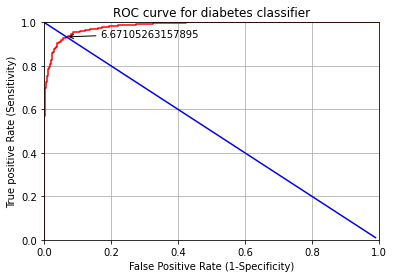

0.4384988

In [ ]:
print('********************Scores on devSet********************')
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/7_6/cnn_viT_layerextractor_custom_batch64_8head_relu_144patches_128filter_blackman_SGD_epochs100_lr0.0001.h5')
#dev_yPred = model_cnn.predict_classes(x_dev)
dev_prediction = model.predict(x_dev)#prob of classes
dev_score = model.evaluate(x_dev, y_dev, verbose=1)

CalEER(devLabel,dev_prediction[:,1])
#analysisModel(devLabel,dev_yPred)

#print('dev loss:', dev_score[0])
#print('dev accuracy:', dev_score[1])

In [ ]:
import pandas as pd

class StringConverter(dict):
    def __contains__(self, item):
        return True

    def __getitem__(self, item):
        return str

    def get(self, default=None):
        return str

df=pd.read_csv('/content/drive/MyDrive/protocol_V2/train_protocol.csv', converters=StringConverter())
test_df = pd.read_csv('/content/drive/MyDrive/protocol_V2/dev_protocol.csv', converters=StringConverter())
eval_df = pd.read_csv('/content/drive/MyDrive/protocol_V2/eval_protocol.csv', converters=StringConverter())

In [ ]:
classes=list(np.unique(eval_df.label))
classes[0], classes[1] = classes[1], classes[0]
classes

['spoof', 'genuine']

In [ ]:
fn2classes=dict(zip(eval_df.wav_id ,eval_df.label))

In [ ]:
def build_prediction(data_fram):
    y_true=[]
    y_pred=[]
    fn_prob={}
    #y_prob=[]

    print('prediction on eval dataset')
    for i, ID in enumerate(data_fram['wav_id']):
      feat= np.load(('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/feature_keras_generator/feature_keras_generator_400_400_100_800/' + ID.split(".")[0] + '.npy'))
      feat=feat.reshape(1, feat.shape[0], feat.shape[1], 1)
      label=fn2classes[ID]
      c=classes.index(label)
      y_hat=model.predict(feat)
      y_prob=[]
      y_prob.append(y_hat)
      y_pred.append(np.argmax(y_hat))
      y_true.append(c)
      fn_prob[ID]=np.mean(y_prob,axis=0).flatten()
    return y_true,y_pred,fn_prob

In [ ]:
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/7_6/cnn_viT_layerextractor_custom_batch64_8head_relu_144patches_128filter_blackman_SGD_epochs100_lr0.0001.h5')
y_true, y_pred, fn_prob=build_prediction(eval_df)

prediction on eval dataset


In [ ]:
print('********************Scores on EvalSet********************')
from sklearn.metrics import accuracy_score
Eval_acc=accuracy_score(y_true, y_pred)
print('Eval accuracy:', Eval_acc)

********************Scores on EvalSet********************
Eval accuracy: 0.8692319254471667


In [ ]:
y_probs=[]
for i , row in eval_df.iterrows():
  y_prob=fn_prob[row.wav_id]
  y_probs.append(y_prob)
  for c,p in zip(classes, y_prob):
    eval_df.at[i,c]=p

In [ ]:
y_pred=[classes[np.argmax(y)] for y in y_probs]
eval_df['y_pred']=y_pred
eval_df.to_csv('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/score_pred/prediction.csv', index=False)

In [ ]:
prediction=pd.read_csv('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/score_pred/prediction.csv')
prediction

,Unnamed: 0,wav_id,label,speaker_id,phrase_id,env_id,pb_device_id,rec_device_id,label_id,wav_path,transcript,duration,spoof,genuine,y_pred
0,0,E_1000001.wav,spoof,M0029,S03,E19,P22,R22,0,/content/drive/Shareddrives/Unlimited Drive | ...,Only lawyers love millionaires,4.1575,0.998699,0.001301,spoof
1,1,E_1000002.wav,spoof,M0027,S10,E19,P22,R22,0,/content/drive/Shareddrives/Unlimited Drive | ...,Necessity is the mother of invention,3.1745,0.995675,0.004325,spoof
2,2,E_1000003.wav,spoof,M0025,S01,E14,P03,R04,0,/content/drive/Shareddrives/Unlimited Drive | ...,My voice is my password,2.6215,0.060682,0.939318,genuine
3,3,E_1000004.wav,spoof,M0035,S10,E12,P16,R11,0,/content/drive/Shareddrives/Unlimited Drive | ...,Necessity is the mother of invention,2.3815,0.999138,0.000862,spoof
4,4,E_1000005.wav,spoof,M0025,S10,E18,P05,R03,0,/content/drive/Shareddrives/Unlimited Drive | ...,Necessity is the mother of invention,3.7725,0.922722,0.077278,spoof
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13301,13301,E_1014215.wav,spoof,M0023,S03,E24,P13,R08,0,/content/drive/Shareddrives/Unlimited Drive | ...,Only lawyers love millionaires,4.1255,0.052301,0.947699,genuine
13302,13302,E_1014216.wav,spoof,M0032,S01,E08,P20,R14,0,/content/drive/Shareddrives/Unlimited Drive | ...,My voice is my password,2.6265,0.992978,0.007022,spoof
13303,13303,E_1014217.wav,genuine,M0021,S04,-,-,-,1,/content/drive/Shareddrives/Unlimited Drive | ...,Artificial intelligence is for real,3.4535,0.422273,0.577727,genuine
13304,13304,E_1014218.wav,spoof,M0024,S06,E19,P22,R22,0,/content/drive/Shareddrives/Unlimited Drive | ...,Actions speak louder than words,4.1355,0.997565,0.002435,spoof


eer_thresholds: 0.6685422
EER_fpr: 11.242504996668888
EER_fnr: 11.248073959938365
EER: 11.245289478303627


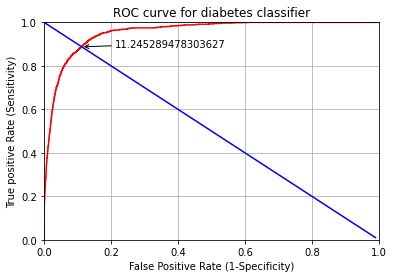

0.6685422

In [ ]:
CalEER(y_true,np.array(y_probs)[:,1])

In [ ]:
#cnn_convolutional_only = Model(model.input,model.get_layer('dense_6').output) # TRUNCATE MODEL AT DENSE LAYER

In [ ]:
trainData = intermediary_model.predict(x_train)

In [ ]:
trainSet = np.c_[y_train,trainData]

In [ ]:
np.savetxt('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/layer_extractor_features/Lcnn_T_400_400_100_800/trcls_dat.csv',trainSet,delimiter=',')

In [ ]:
del trainData,trainSet,x_train,y_train

In [ ]:
gc.collect()

1601

In [ ]:
#Extract Data

devData = intermediary_model.predict(x_dev)
devSet = np.c_[y_dev,devData]

In [ ]:
np.savetxt('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/layer_extractor_features/Lcnn_T_400_400_100_800/devcls_dat.csv',devSet,delimiter=',')
#np.savetxt('te_dat.csv',testSet,delimiter=',')

In [ ]:
del devData,devSet,x_dev,y_dev
gc.collect()

757

In [ ]:
evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/eval/eval_1.npy')
evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/eval_lable/eval_1_label.npy')

In [ ]:
img_rows, img_cols =evalData[0].shape
x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)

In [ ]:
testData = intermediary_model.predict(x_test)

In [ ]:
testData

array([[ 0.42069027, -1.4590051 , -2.312179  , ...,  0.15525189,
         0.98501563, -0.84841645],
       [ 0.41569492, -1.299459  , -1.9689187 , ...,  0.12073587,
         1.1600192 , -0.6227683 ],
       [ 0.3464546 , -1.1287193 , -0.4029428 , ..., -0.05021841,
         0.78217846, -0.8093596 ],
       ...,
       [ 0.37838006, -1.3634173 , -1.0410647 , ...,  0.00357321,
         0.7160824 , -1.0918902 ],
       [ 0.41974536, -0.5399785 ,  0.22488424, ...,  0.07790546,
         0.6570823 ,  0.01032384],
       [ 0.5036715 , -1.1413951 , -1.8586212 , ...,  0.23365745,
         1.1219784 , -0.44035858]], dtype=float32)

In [ ]:
testSet

array([[ 1.        ,  0.        ,  0.42069027, ...,  0.15525189,
         0.98501563, -0.84841645],
       [ 1.        ,  0.        ,  0.41569492, ...,  0.12073587,
         1.1600192 , -0.6227683 ],
       [ 1.        ,  0.        ,  0.3464546 , ..., -0.05021841,
         0.78217846, -0.8093596 ],
       ...,
       [ 1.        ,  0.        ,  0.37838006, ...,  0.00357321,
         0.7160824 , -1.0918902 ],
       [ 1.        ,  0.        ,  0.41974536, ...,  0.07790546,
         0.6570823 ,  0.01032384],
       [ 1.        ,  0.        ,  0.5036715 , ...,  0.23365745,
         1.1219784 , -0.44035858]], dtype=float32)

In [ ]:
testSet = np.c_[y_test,testData]

In [ ]:
del x_test,y_test,testData
gc.collect()

958

In [ ]:
evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/eval/eval_2.npy')
evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/eval_lable/eval_2_label.npy')
img_rows, img_cols =evalData[0].shape
x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)

In [ ]:
testData = intermediary_model.predict(x_test)

In [ ]:
testSet1 = np.c_[y_test,testData]

In [ ]:
del x_test,y_test,testData
gc.collect()

734

In [ ]:
evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/eval/eval_3.npy')
evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/eval_lable/eval_3_label.npy')
img_rows, img_cols =evalData[0].shape
x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)

In [ ]:
testData = intermediary_model.predict(x_test)

In [ ]:
testSet2 = np.c_[y_test,testData]

In [ ]:
del x_test,y_test,testData
gc.collect()

709

In [ ]:
evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/eval/eval_4.npy')
evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/eval_lable/eval_4_label.npy')
img_rows, img_cols =evalData[0].shape
x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)

In [ ]:
testData = intermediary_model.predict(x_test)

In [ ]:
testSet3 = np.c_[y_test,testData]

In [ ]:
del x_test,y_test,testData
gc.collect()

708

In [ ]:
import pandas as pd
final_testset=np.concatenate((testSet, testSet1,testSet2,testSet3), axis = 0)

In [ ]:
np.savetxt('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/layer_extractor_features/Lcnn_T_400_400_100_800/tecls_dat.csv',final_testset,delimiter=',')

#ta inja

In [ ]:
model,intermediary_model = buildLcnn_T()

print(model.summary())
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model.png', show_shapes=True)

In [ ]:
preds = model.predict(np.expand_dims(x_train[0], axis=0))

In [ ]:
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
last_conv_layer = model.get_layer('conv2d_8')
import cv2
class GradCAM:
    def __init__(self, model, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

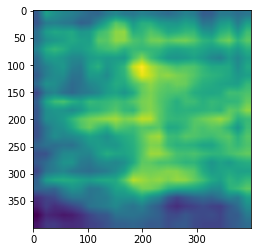

In [ ]:
icam = GradCAM(model, 'conv2d_8') 
heatmap = icam.compute_heatmap(np.expand_dims(x_train[0], axis=0))
#heatmap = cv2.resize(heatmap, (32, 32))
fig, ax = plt.subplots(1)

ax.imshow(heatmap)

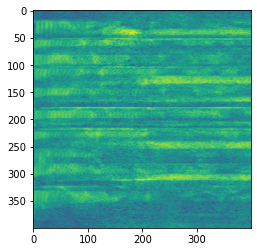

In [ ]:
image = x_train[0][:,:,0]
#image = cv2.resize(image, (32, 32))
print(heatmap.shape, image.shape)
fig, ax = plt.subplots(1)

ax.imshow(image)

In [ ]:
(heatmap, out) = icam.overlay_heatmap(heatmap, image, alpha=0.5)
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(out)